In [6]:
import os
import torch
import pickle
from tqdm import tqdm
from time import perf_counter
import matplotlib.pyplot as plt

from axb.krylov import gmres
from axb.interface import HelmholtzOperator
from axb.interface import HybridNetOperator
from axb.interface import NormHybridNetOperator

from helmnet import IterativeSolver
from helmnet import MRRIterativeSolver
from helmnet import MRRNIterativeSolver
from helmnet import MRRYIterativeSolver
from helmnet import MRRNYIterativeSolver

from helmnet.dataloaders import get_dataset
from helmnet.support_functions import normalize_wavefield

device = 'cuda'

is_gpu_used = device == 'cuda'
if is_gpu_used:
    import cupy as xp
else:
    import numpy as xp
    

def plot_solution(x, sos_map):
    sol = xp.real(x.reshape(96, 96))
    if is_gpu_used:
        sol = xp.asnumpy(sol)

    plt.figure(figsize=(3, 3))
    plt.imshow(sos_map)
    plt.imshow(sol, alpha=0.9)
    plt.show()
    
    
def run_test(M=None, M_type="v", verbose=0, return_x=False):
    residuals = []

    def callback(r):
        nonlocal residuals
        residuals.append(r.get() if is_gpu_used else r)

    s = perf_counter()
    x, info = gmres(A, b, M=M, M_type=M_type, K_dim=50, restarts=50, tol=1e-16, callback=callback)
    if verbose > 0:
        print(f"Solving time: {perf_counter() - s:.4f}s\n")
        print(f"||Ax - b|| / ||b|| = {xp.linalg.norm(A(x) - b) / xp.linalg.norm(b):.3e}")
    residuals = xp.asarray(residuals)
    if return_x:
        residuals, x
    return residuals

In [20]:
workdir = "/home/maksym/Work/INRIA/repos/gitlab/helmnet-exp"

path_to_checkpoint_base = os.path.join(workdir, "checkpoints_kraken6", "base", "base", "epoch=213-step=60134.ckpt")
# path_to_checkpoint_mrr = os.path.join(workdir, "checkpoints_kraken6", "mrr", "epoch=25-step=7306-v1.ckpt")
# path_to_checkpoint_mrr = os.path.join(workdir, "checkpoints", "mrr", "last-v4.ckpt")
# path_to_checkpoint_mrr = os.path.join(workdir, "checkpoints_kraken7", "mrr", "epoch=9-step=2810-v2.ckpt")
path_to_checkpoint_mrrn = os.path.join(workdir, "chkp_mrrn_v2", "mrrn", "epoch=27-step=7868.ckpt")
# path_to_checkpoint_mrr = os.path.join(workdir, "checkpoints", "mrry", "epoch=17-step=5058.ckpt")
# path_to_checkpoint_mrr = os.path.join(workdir, "checkpoints_261022", "mrry", "epoch=15-step=4496.ckpt")
# path_to_checkpoint_mrrn = os.path.join(workdir, "checkpoints_kraken6", "mrrn", "epoch=15-step=4496.ckpt")
path_to_checkpoint_mrrn = os.path.join(workdir, "checkpoints", "yanfei.ckpt")

path_to_dataset = os.path.join(workdir, "datasets", "splitted_96", "testset.ph")

In [21]:
solver_base = IterativeSolver.load_from_checkpoint(
    path_to_checkpoint_base, strict=False, test_data_path=None,
)

solver_base.freeze()
solver_base.to(device);

solver_mrr = MRRIterativeSolver.load_from_checkpoint(
    path_to_checkpoint_mrr, strict=False, test_data_path=None,
)

solver_mrr.freeze()
solver_mrr.to(device);

solver_mrrn = MRRNIterativeSolver.load_from_checkpoint(
    path_to_checkpoint_mrrn, strict=False, test_data_path=None,
)

solver_mrrn.freeze()
solver_mrrn.to(device);

testset = get_dataset(path_to_dataset)

b = solver_base.source.data[0]
b = torch.complex(b[0], b[1])
b = torch.reshape(b, (-1, 1))
b = xp.asarray(b)
b_norm = xp.linalg.norm(b)
if is_gpu_used:
    b_norm = b_norm.get()

In [22]:
num_problems = 3

gmres_dict = {
#     "gmres": [],
    "gmres_xr": [],
    "gmres_0v": [],
#     "gmres_mrr_xr": [],
#     "gmres_mrr_0v": [],
    "gmres_mrrn_xr": [],
    "gmres_mrrn_0v": [],
}

for problem_id in tqdm(range(num_problems)):


    sos_map = testset.all_sos_numpy[problem_id]
    sos_maps = torch.tensor(
        sos_map[xp.newaxis, xp.newaxis],
        device=device,
    ).float()
    k_sq, initial_guess = solver_base.get_initials(sos_maps)


    A = HelmholtzOperator(solver_base, sos_map)
    
#     gmres_dict["gmres"].append(run_test())
    
    M = NormHybridNetOperator(solver_base, sos_map, norm_mask=[False, True])

    gmres_dict["gmres_xr"].append(run_test(M, M_type="xr"))
    gmres_dict["gmres_0v"].append(run_test(M, M_type="0v"))
    
#     M = NormHybridNetOperator(solver_mrr, sos_map, norm_mask=[False, True])

#     gmres_dict["gmres_mrr_xr"].append(run_test(M, M_type="xr"))
#     gmres_dict["gmres_mrr_0v"].append(run_test(M, M_type="0v"))
    
    M = NormHybridNetOperator(solver_mrrn, sos_map, norm_mask=[False, True])

    gmres_dict["gmres_mrrn_xr"].append(run_test(M, M_type="xr"))
    gmres_dict["gmres_mrrn_0v"].append(run_test(M, M_type="0v"))
    
# with open('gmres_dict.pkl', 'wb') as handle:
#     pickle.dump(gmres_dict, handle)

100%|█████████████████████████████████████████████| 3/3 [03:16<00:00, 65.36s/it]


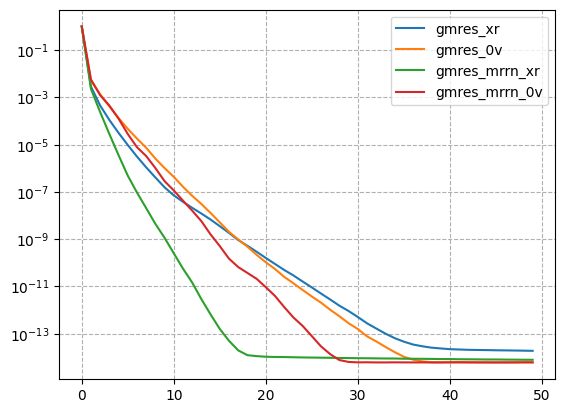

In [23]:
gmres_dict_mean = {key: xp.mean(xp.asarray(gmres_dict[key]), axis=0) for key in gmres_dict}

for key in gmres_dict:
    plt.plot(gmres_dict_mean[key].get() if is_gpu_used else gmres_dict_mean[key], label=key)
    
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--')
# plt.savefig("yanfei_weights.png")
plt.show()

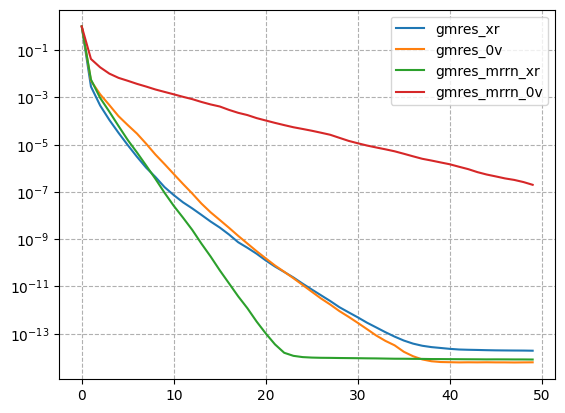

In [17]:
gmres_dict_mean = {key: xp.mean(xp.asarray(gmres_dict[key]), axis=0) for key in gmres_dict}

for key in gmres_dict:
    plt.plot(gmres_dict_mean[key].get() if is_gpu_used else gmres_dict_mean[key], label=key)
    
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--')
# plt.savefig("yanfei_weights.png")
plt.show()

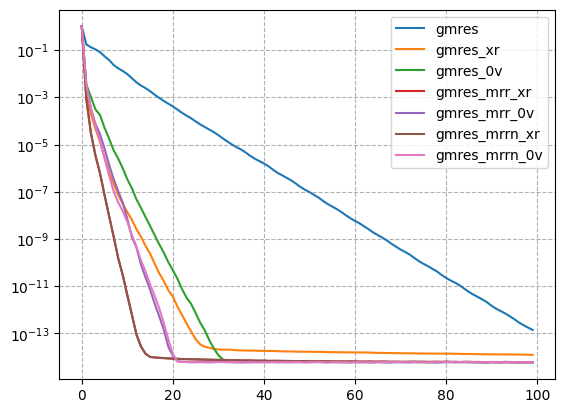

In [6]:
gmres_dict_median = {key: xp.median(xp.asarray(gmres_dict[key]), axis=0) for key in gmres_dict}

for key in gmres_dict:
    plt.plot(gmres_dict_median[key].get() if is_gpu_used else gmres_dict_median[key], label=key)
    
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

In [7]:
import numpy as np

nn_dict = {
    "nn": [],
    "mrr": [],
    "mrrn": [],
}

for problem_id in tqdm(range(num_problems)):

    sos_map = testset.all_sos_numpy[problem_id]
    sos_maps = torch.tensor(
        sos_map[xp.newaxis, xp.newaxis],
        device=device,
    ).float()
    k_sq, initial_guess = solver_base.get_initials(sos_maps)

    solver_base.f.clear_states(initial_guess)
    output = solver_base.forward(
        sos_maps,
        num_iterations=5000,
        return_wavefields=True,
        return_states=False,
    )

    res_nn = [1.] + np.array([torch.norm(torch.complex(r[0, 0], r[0, 1])).cpu().numpy() / b_norm for r in output["residuals"]])[::50][:-1].tolist()
    nn_dict["nn"].append(np.asarray(res_nn))
    
    solver_mrr.f.clear_states(initial_guess)
    output = solver_mrr.forward(
        sos_maps,
        num_iterations=5000,
        return_wavefields=True,
        return_states=False,
    )

    res_mrr_nn = [1.] + np.array([torch.norm(torch.complex(r[0, 0], r[0, 1])).cpu().numpy() / b_norm for r in output["residuals"]])[::50][:-1].tolist()
    nn_dict["mrr"].append(np.asarray(res_mrr_nn))
    
    solver_mrrn.f.clear_states(initial_guess)
    output = solver_mrrn.forward(
        sos_maps,
        num_iterations=5000,
        return_wavefields=True,
        return_states=False,
    )

    res_mrrn_nn = [1.] + np.array([torch.norm(torch.complex(r[0, 0], r[0, 1])).cpu().numpy() / b_norm for r in output["residuals"]])[::50][:-1].tolist()
    nn_dict["mrrn"].append(np.asarray(res_mrrn_nn))
    
# with open('nn_dict.pkl', 'wb') as handle:
#     pickle.dump(nn_dict, handle)

100%|█████████████████████████████████████████████| 1/1 [01:03<00:00, 63.96s/it]


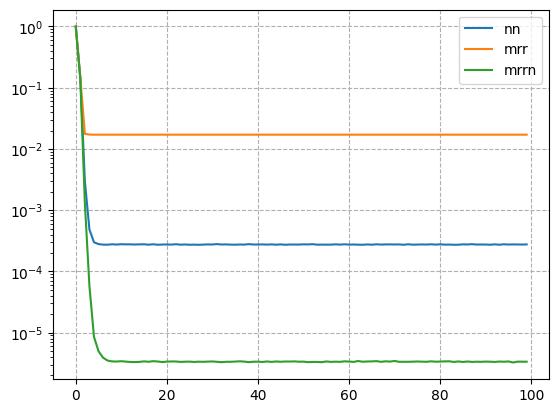

In [8]:
nn_dict_mean = {key: np.mean(np.asarray(nn_dict[key]), axis=0) for key in nn_dict}

for key in nn_dict:
    plt.plot(nn_dict_mean[key], label=key)
    
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

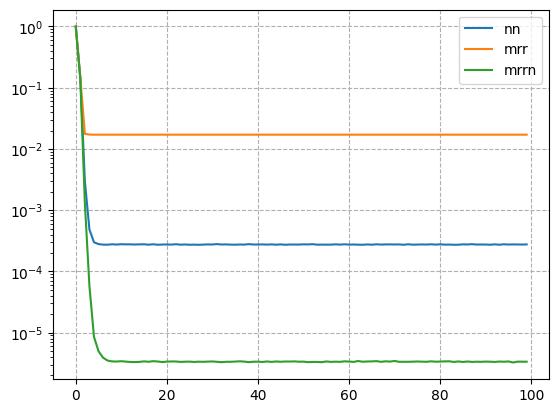

In [9]:
nn_dict_median = {key: np.median(np.asarray(nn_dict[key]), axis=0) for key in nn_dict}

for key in nn_dict:
    plt.plot(nn_dict_median[key], label=key)
    
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()